# The Code

In [4]:
import pandas as pd;
column_map = { 'date': 'Date','IoE':'Income/Expenses', 'category':'Category', 'memo': 'Memo', 'amount':'Amount'};
column_keys = list(column_map.keys());
print(column_keys)

['date', 'IoE', 'category', 'memo', 'amount']


In [5]:
data = pd.read_csv("data.csv",delimiter = ',');
yearWiseData =[];

In [6]:
from datetime import date

def getDate(str):
    date_tokenized = str.split('-')
    return date(int(date_tokenized[0]), int(date_tokenized[1]), int(date_tokenized[2]))

In [7]:
def getCategories():
    return data[column_map['category']].unique()

print(getCategories());

['Food' 'home bills' 'Transportation' 'Refunds' 'Home' 'Gift' 'Education'
 'Travel' 'Social' 'mumbai groceries' 'mumbai flat' 'Electronics'
 'during work snack' 'lend return' 'Others' 'Shopping' 'Car' 'petrol'
 'Wine' 'pocket money' 'Health' 'Cigarette' 'Office' 'lend' 'Bills'
 'Clothing' 'carry on' 'carry on to next month' 'Grants' 'Telephone']


In [8]:
def mergeDailyExpenseData(data):
    unique_dates = data[column_map['date']].unique()
    #print(len(unique_dates))
    #print(data.loc[data['Date'] == '2019-11-14'])
    
    daily = []
    #expense = data.loc[data['Amount']<0]
    #expense = data;
    for unique_date in unique_dates:
        
        categories = data.loc[data['Date'] == unique_date][column_map['category']].unique();
        l='';
        for c in categories:
            l = l+',' + c;
        l= l[1:];
        memos = data.loc[data['Date'] == unique_date][column_map['memo']].unique();
        s='';
        for c in memos:
            s = s+',' +str(c);
        s= s[1:];
        daily.append({'Date': unique_date, 'Category': l, 'Memo': s, 'Amount': -1*np.sum(data.loc[data['Date'] == unique_date][column_map['amount']].values)});
        
    return pd.DataFrame.from_dict(daily, orient='columns');

In [9]:
def getDataForColumns(data, column_bitmask, fromDate, toDate, mergeDailyData):
    columns = [];
    
    for i in range(len(column_bitmask)):
        if column_bitmask[i] == 1:
            columns.append(column_map[column_keys[i]]);
    
    if mergeDailyData == True:
        df = mergeDailyExpenseData(data);
        if fromDate == '' and toDate == '':
            return df
    
        fromDate = getDate(fromDate);
        toDate = getDate(toDate);

        for index, row in df.iterrows():
            currDate = getDate(row[column_map['date']]);
            if currDate < fromDate or currDate > toDate:
                df.drop(index, inplace=True)

        return df[columns].copy();
    
    
    df = data[columns].copy();
        
    if fromDate == '' and toDate == '':
        return df
    
    fromDate = getDate(fromDate);
    toDate = getDate(toDate);
    
    for index, row in df.iterrows():
        currDate = getDate(row[column_map['date']]);
        if currDate < fromDate or currDate > toDate:
            df.drop(index, inplace=True)
    return df;
    

In [10]:
def getDataForCategory(data, category, fromDate, toDate, isMergeData):
    frame = getDataForColumns(data, [1, 1, 1, 1, 1], fromDate, toDate, isMergeData)    
    if category == '':
        return frame;
    #frame = frame[frame.Category == category]
    for index, row in frame.iterrows():
        if category not in row[column_map['category']]:
            frame.drop(index, inplace=True)
    return frame;

### Visualisation functions

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")

def createBarPlot(x, y, x_dim, y_dim):
    plt.figure(figsize=(x_dim, y_dim))
    plt.xlabel('xlabel', fontsize=3)
    plt.xticks(rotation=90)
    plt.bar(x,y)
    plt.show()
    
def createLinePlot(x, y, x_dim, y_dim):
    plt.figure(figsize=(x_dim, y_dim))
    plt.xlabel('xlabel', fontsize=3)
    plt.xticks(rotation=90)
    plt.plot(x,y)
    plt.show()
    
def createBubblePlot(x, y, z, x_dim, y_dim):
    plt.figure(figsize=(x_dim, y_dim))
    plt.scatter(x, y, s=z*2000, c=x, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)
 
    # Add titles (main and on axis)
    plt.xlabel("the X axis")
    plt.ylabel("the Y axis")
    plt.title("A colored bubble plot")

    plt.show()

In [12]:
def showResult(dic):
    hr =      '###############################################################\n'
    keys = list(dic.keys());
    values = list(dic.values());
    
    if 'Title' not in keys:
        dic['Title'] = 'Title not specified'; 
        keys.append('Title')
        values.append('Title not specified')
    
    result = '';
    
    heading = '#              '+dic['Title'].upper()+'\n'
    
    result+=hr;
    result+=heading;
    
    for i in range(len(keys)):
        if keys[i] != 'Title':
            result+= '# '+keys[i]+' : '+str(values[i])+'\n'
    print(result+hr);

In [13]:
import numpy as np

def getTotalExpenditure(data):
    
    result={};
    category_expenses = [];
    startDate = data['Date'].iloc[-1] # first element 
    endDate = data['Date'].iloc[0] # last element 
    categoricalExpenditure = [];
    for category in getCategories():
        category_data = getDataForCategory(data, category, '', '', False);
        
        category_expense = category_data[column_map['amount']].values;
        category_expenses.append(-1*np.sum(category_expense));
        dates = category_data[column_map['date']].values
        if(len(dates)!=0):
            first = getDate(dates[len(dates)-1])
            last = getDate(dates[0])
            categoricalExpenditure.append({'category':category, 'startDate': first, 'lastDate': last, 'expense': -1*np.sum(category_expense), 'data': category_data});

    result['Expense'] = category_expenses;
    result['categoricalExpenditure'] = categoricalExpenditure;
    return result;
    

In [14]:
def getUniqueYears():
    unique_dates = data[column_map['date']].unique()

    unique_years = np.empty(len(unique_dates))
    
    for index in range(len(unique_dates)):
        unique_years[index] = str(getDate(unique_dates[index]).year)
        
    return np.unique(unique_years)

In [15]:
def getYearlyData():

    unique_years = getUniqueYears()
    #print(unique_years)
    yearly_data = [];
    
    df = data.copy();
    for year in unique_years:
        
        yearly = [];
        for index, row in df.iterrows():
            currYear = getDate(row[column_map['date']]).year;
            if currYear == year:
                yearly.append(row);
                df.drop(index, inplace=True)
                
                
        yearly_data.append({'year': currYear, 'data': pd.DataFrame(yearly, columns = column_map.values())})

    return yearly_data

In [16]:

def getDataForYear(year):
    global yearWiseData
    if len(yearWiseData) == 0:
        yearWiseData = getYearlyData();
        
    for yearly in yearWiseData:
        if yearly['year'] == year:
            return yearly['data'];
        
    #if data for year does not exist
    return pd.DataFrame(columns=column_map.values())
            

In [17]:
import calendar;

def getMonthlyData():
    
    monthly_data = []
    global yearWiseData
    unique_years = getUniqueYears();
    for year in unique_years:
        yearlyData = getDataForYear(year)
        
        unique_dates = yearlyData[column_map['date']].unique()
        unique_months = np.empty(len(unique_dates))

        for index in range(len(unique_dates)):
            unique_months[index] = str(getDate(unique_dates[index]).month)

        unique_months = np.unique(unique_months)
        
        for month in unique_months:
            m='';
            if(month < 10):
                m = '0'+str(int(month));
            else:
                m = str(int(month))
            
            year = int (year)
            startDate = str(year)+'-'+str(m)+'-01';
            endDate = str(year)+'-'+str(m)+'-'+ str(int(calendar.monthrange(int(year),int(month))[1]))
            monthly_data.append({'monthStart': startDate, 'monthEnd': endDate, 'data':getDataForCategory(yearlyData, '', startDate, endDate, False)});
    return monthly_data;

In [18]:
#print(getDataForCategory(data, 'Transportation', ' 2019-10-01', ' 2019-10-30', False));

 # Data & Visualisations

## Total expenditures data

###############################################################
#              ALL TIME CATEGORICAL EXPENDITURE
# Expense : -90910.09
###############################################################



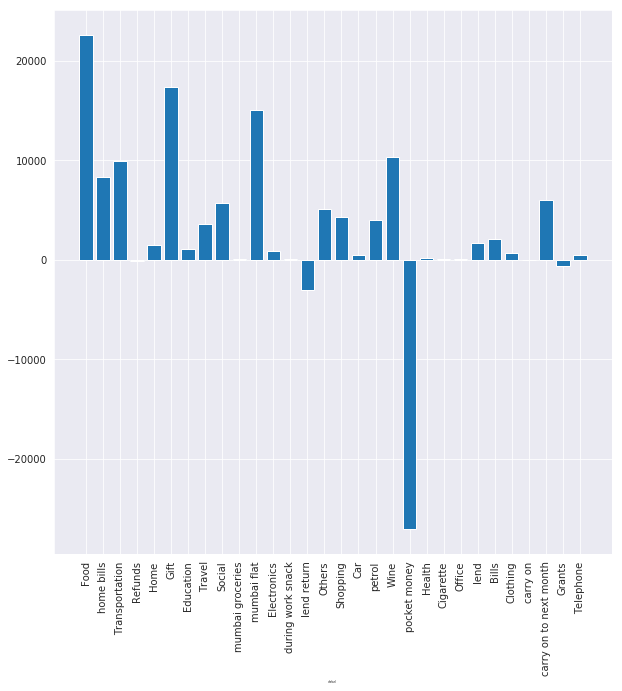

In [19]:
categorical_expenditure = getTotalExpenditure(data)
showResult({'Title': 'All Time Categorical Expenditure', 'Expense': -1*np.sum(categorical_expenditure['Expense'])});
ce = categorical_expenditure['categoricalExpenditure'];

categories = []
expenses = []

#{'category':category, 'startDate': first, 'lastDate': last, 'expense': -1*np.sum(category_expense), 'data': category_data}
for c in ce:
    #showResult({'Title': 'Category: '+c['category'], 'Days: ':c['lastDate']-c['startDate'],'Expense': c['expense']});
    categories.append(c['category']);
    expenses.append(c['expense']);
    
createBarPlot(categories, expenses, 10,10)

## Monthly expenditures

For Month:  11  Year:  2018


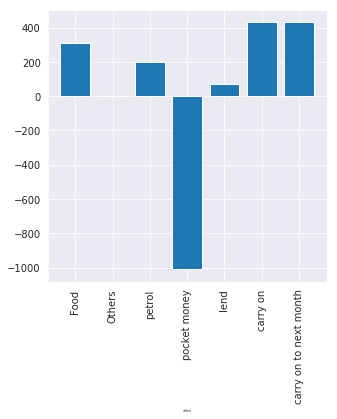

For Month:  12  Year:  2018


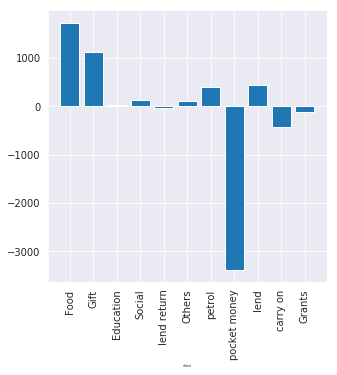

For Month:  01  Year:  2019


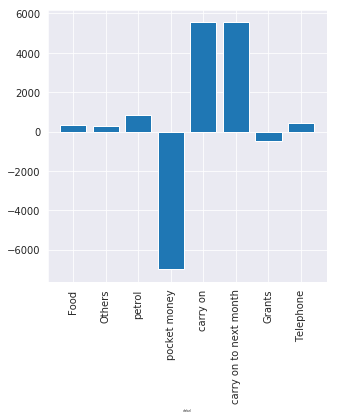

For Month:  02  Year:  2019


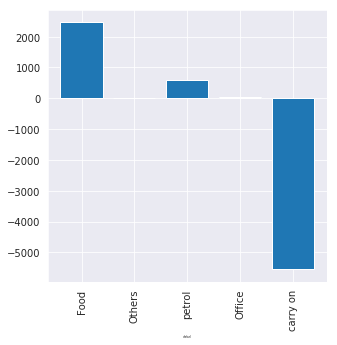

For Month:  03  Year:  2019


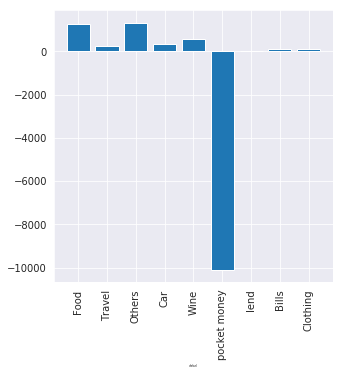

For Month:  05  Year:  2019


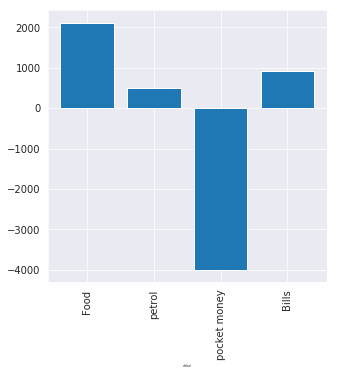

For Month:  08  Year:  2019


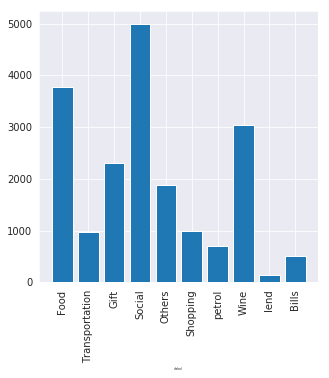

For Month:  09  Year:  2019


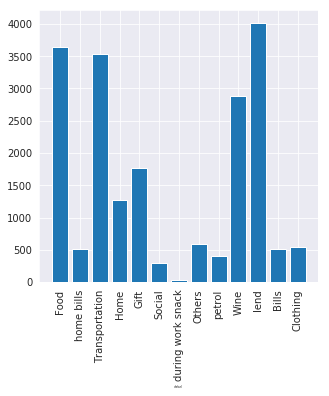

For Month:  10  Year:  2019


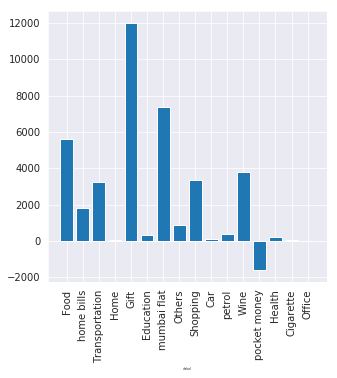

For Month:  11  Year:  2019


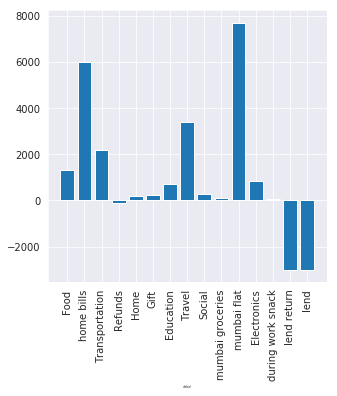

In [20]:
monthly_expenditure = getMonthlyData()
for month in monthly_expenditure:
    categorical_expenditure = getTotalExpenditure(month['data']);
    ce = categorical_expenditure['categoricalExpenditure'];
    
    categories = []
    expenses = []

    #{'category':category, 'startDate': first, 'lastDate': last, 'expense': -1*np.sum(category_expense), 'data': category_data}
    for c in ce:
        #showResult({'Title': 'Category: '+c['category'], 'Days: ':c['lastDate']-c['startDate'],'Expense': c['expense']});
        categories.append(c['category']);
        expenses.append(c['expense']);
    m_split = month['monthStart'].split('-')
    print('For Month: ',m_split[1],' Year: ', m_split[0])
    createBarPlot(categories, expenses, 5,5)
    

## Custom Queries

### Get Data For Individual categories 

In [21]:
print('Following are the categories')
print(getCategories())

Following are the categories
['Food' 'home bills' 'Transportation' 'Refunds' 'Home' 'Gift' 'Education'
 'Travel' 'Social' 'mumbai groceries' 'mumbai flat' 'Electronics'
 'during work snack' 'lend return' 'Others' 'Shopping' 'Car' 'petrol'
 'Wine' 'pocket money' 'Health' 'Cigarette' 'Office' 'lend' 'Bills'
 'Clothing' 'carry on' 'carry on to next month' 'Grants' 'Telephone']


In [22]:
print(np.sum(getTotalExpenditure(getDataForCategory(data, 'Transportation', '2019-08-26', '2019-11-15', False))['Expense']))

9372.0


### Food expenditure other than the essential breakfast, lunch, freakfast

In [23]:
dataa = getDataForCategory(data, 'Food', '2019-08-26', '2019-11-30', False)
for index, row in dataa.iterrows():
    row['Memo'] = str(row['Memo']).lower()
    if row['Memo'] in ['lunch', 'breakfast', 'dinner']:
        dataa.drop(index, inplace=True)
        
print(-1*np.sum(getTotalExpenditure(getDataForCategory(dataa, '', '', '', False))['categoricalExpenditure'][0]['data']['Amount'].values)/3)

1500.6666666666667


### Average for category between dates

In [24]:
dataa = getDataForCategory(data, '', '2019-11-01', '2019-11-16', False)
#Averave
print(-1*np.sum(getTotalExpenditure(getDataForCategory(dataa, '', '', '', False))['categoricalExpenditure'][0]['data']['Amount'].values)/16)

82.3125


### Comparing a category on a monthly basis

Average:  1034.4


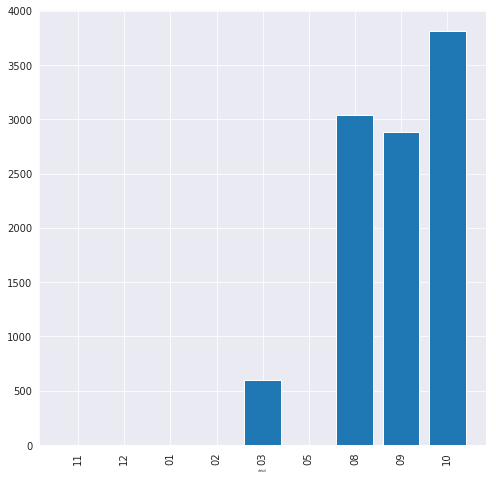

In [25]:
monthly_data = getMonthlyData()

months = [];
expense = [] 

for monthly in monthly_data:
    monthly['data'] = getDataForCategory(monthly['data'], 'Wine', '', '', False)
    monthly['expense'] = -1*np.sum(monthly['data'][column_map['amount']].values)
    months.append(monthly['monthStart'].split('-')[1])
    expense.append(monthly['expense'])

print('Average: ', np.sum(np.array(expense))/len(months))
createBarPlot(months, expense, 8, 8);

### Comparing monthly line plots for a category



Line Plot for:  08 / 2019


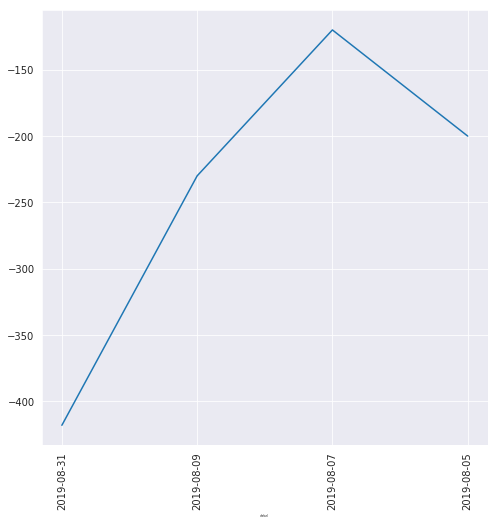



Line Plot for:  09 / 2019


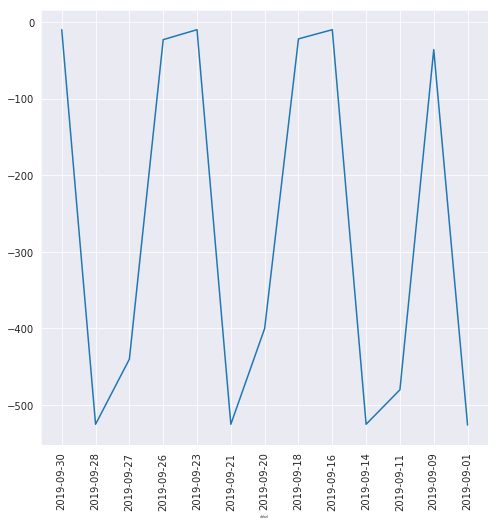



Line Plot for:  10 / 2019


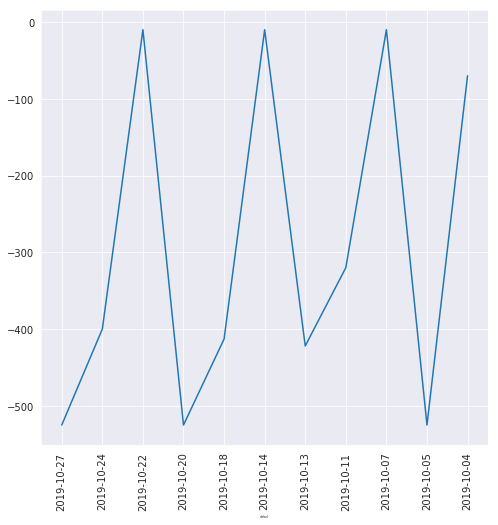



Line Plot for:  11 / 2019


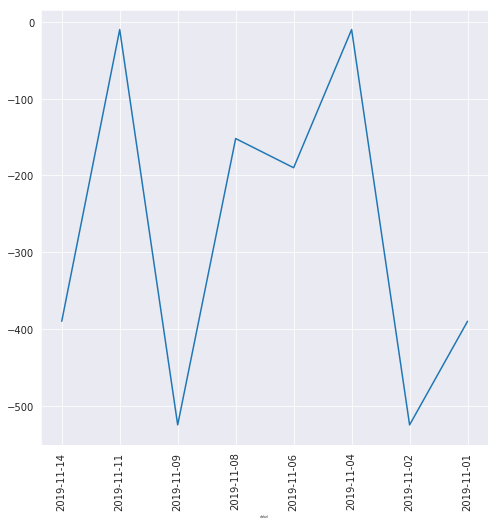

In [26]:
import calendar;

monthly_data = getMonthlyData()

for monthly in monthly_data:
    monthly['data'] = getDataForCategory(monthly['data'], 'Transportation', '', '', False)
    
    monthly['data'] = mergeDailyExpenseData(monthly['data'])
    #print(monthly['data'])
    monthStart = monthly['monthStart'].split('-');
    
    daysInAMonth = calendar.monthrange(int(monthStart[0]), int(monthStart[1]))[1];
    
    if monthly['data'].empty == False:
        print('\n\nLine Plot for: ', monthStart[1],'/',monthStart[0])
        createLinePlot(monthly['data'][column_map['date']], -1*monthly['data'][column_map['amount']].values, 8, 8);
    

### Line graphs for all categories

/home/work/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 1.02, 'Categorical data: ')

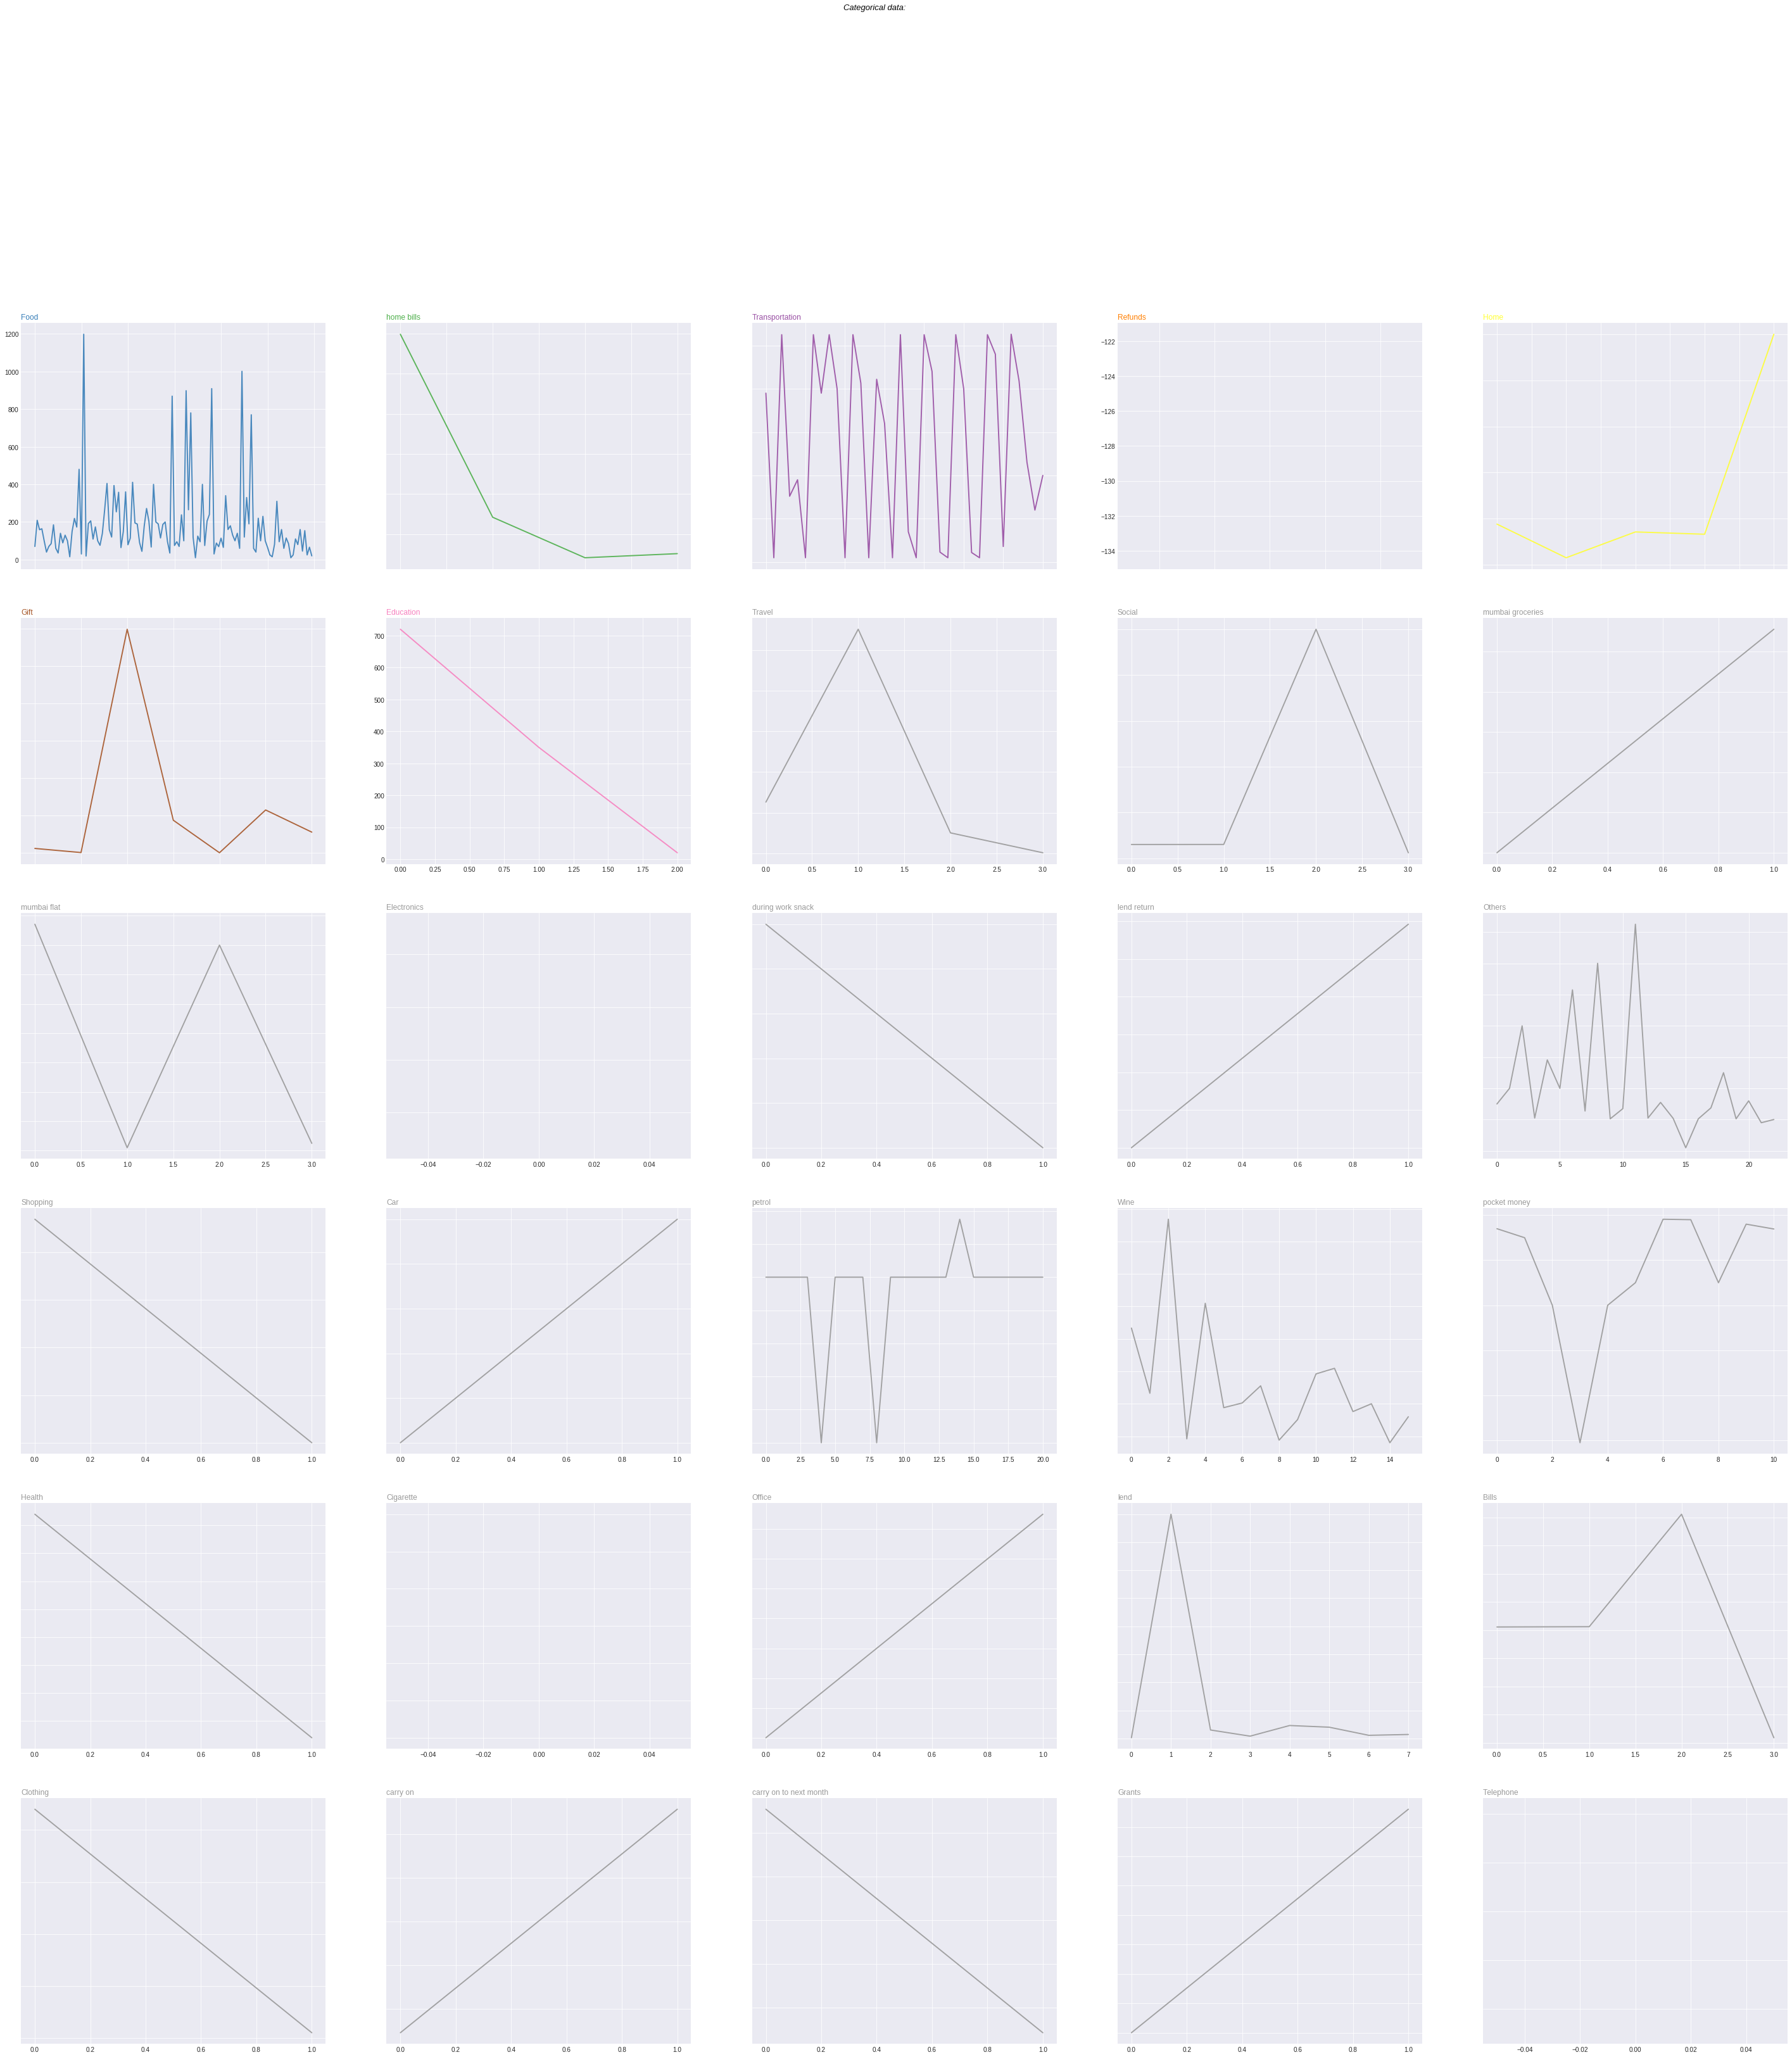

In [27]:
#libraries and data

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

#Initialize the figure

plt.style.use('seaborn-darkgrid')

#create a color palette
palette = plt.get_cmap('Set1')

startDate = ''; endDate = '';

df = getDataForCategory(data.copy(), '', startDate , endDate, False)

expenses = []; size = 0;

plt.figure(figsize=(50,50))

num=0; 

for category in getCategories(): 
    num=num+1; 
    m = mergeDailyExpenseData(df.loc[df['Category'] == category])

    #if m['Amount'].empty == False:
    e= []
    if m.empty ==False:
        e = m['Amount'].values;



    if len(e)>size:
        size = e.size

    expenses.append(e)

    # Find the right spot on the plot
    plt.subplot(6,5, num)

    # Plot the lineplot
    plt.plot(list(range(0, len(e))), e, marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=category)

    # Not ticks everywhere
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')

    # Add title
    plt.title(category, loc='left', fontsize=12, fontweight=0, color=palette(num) )

#general title

plt.suptitle("Categorical data: ", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

### Spaghetti Plot

Text(0, 0.5, 'Time')

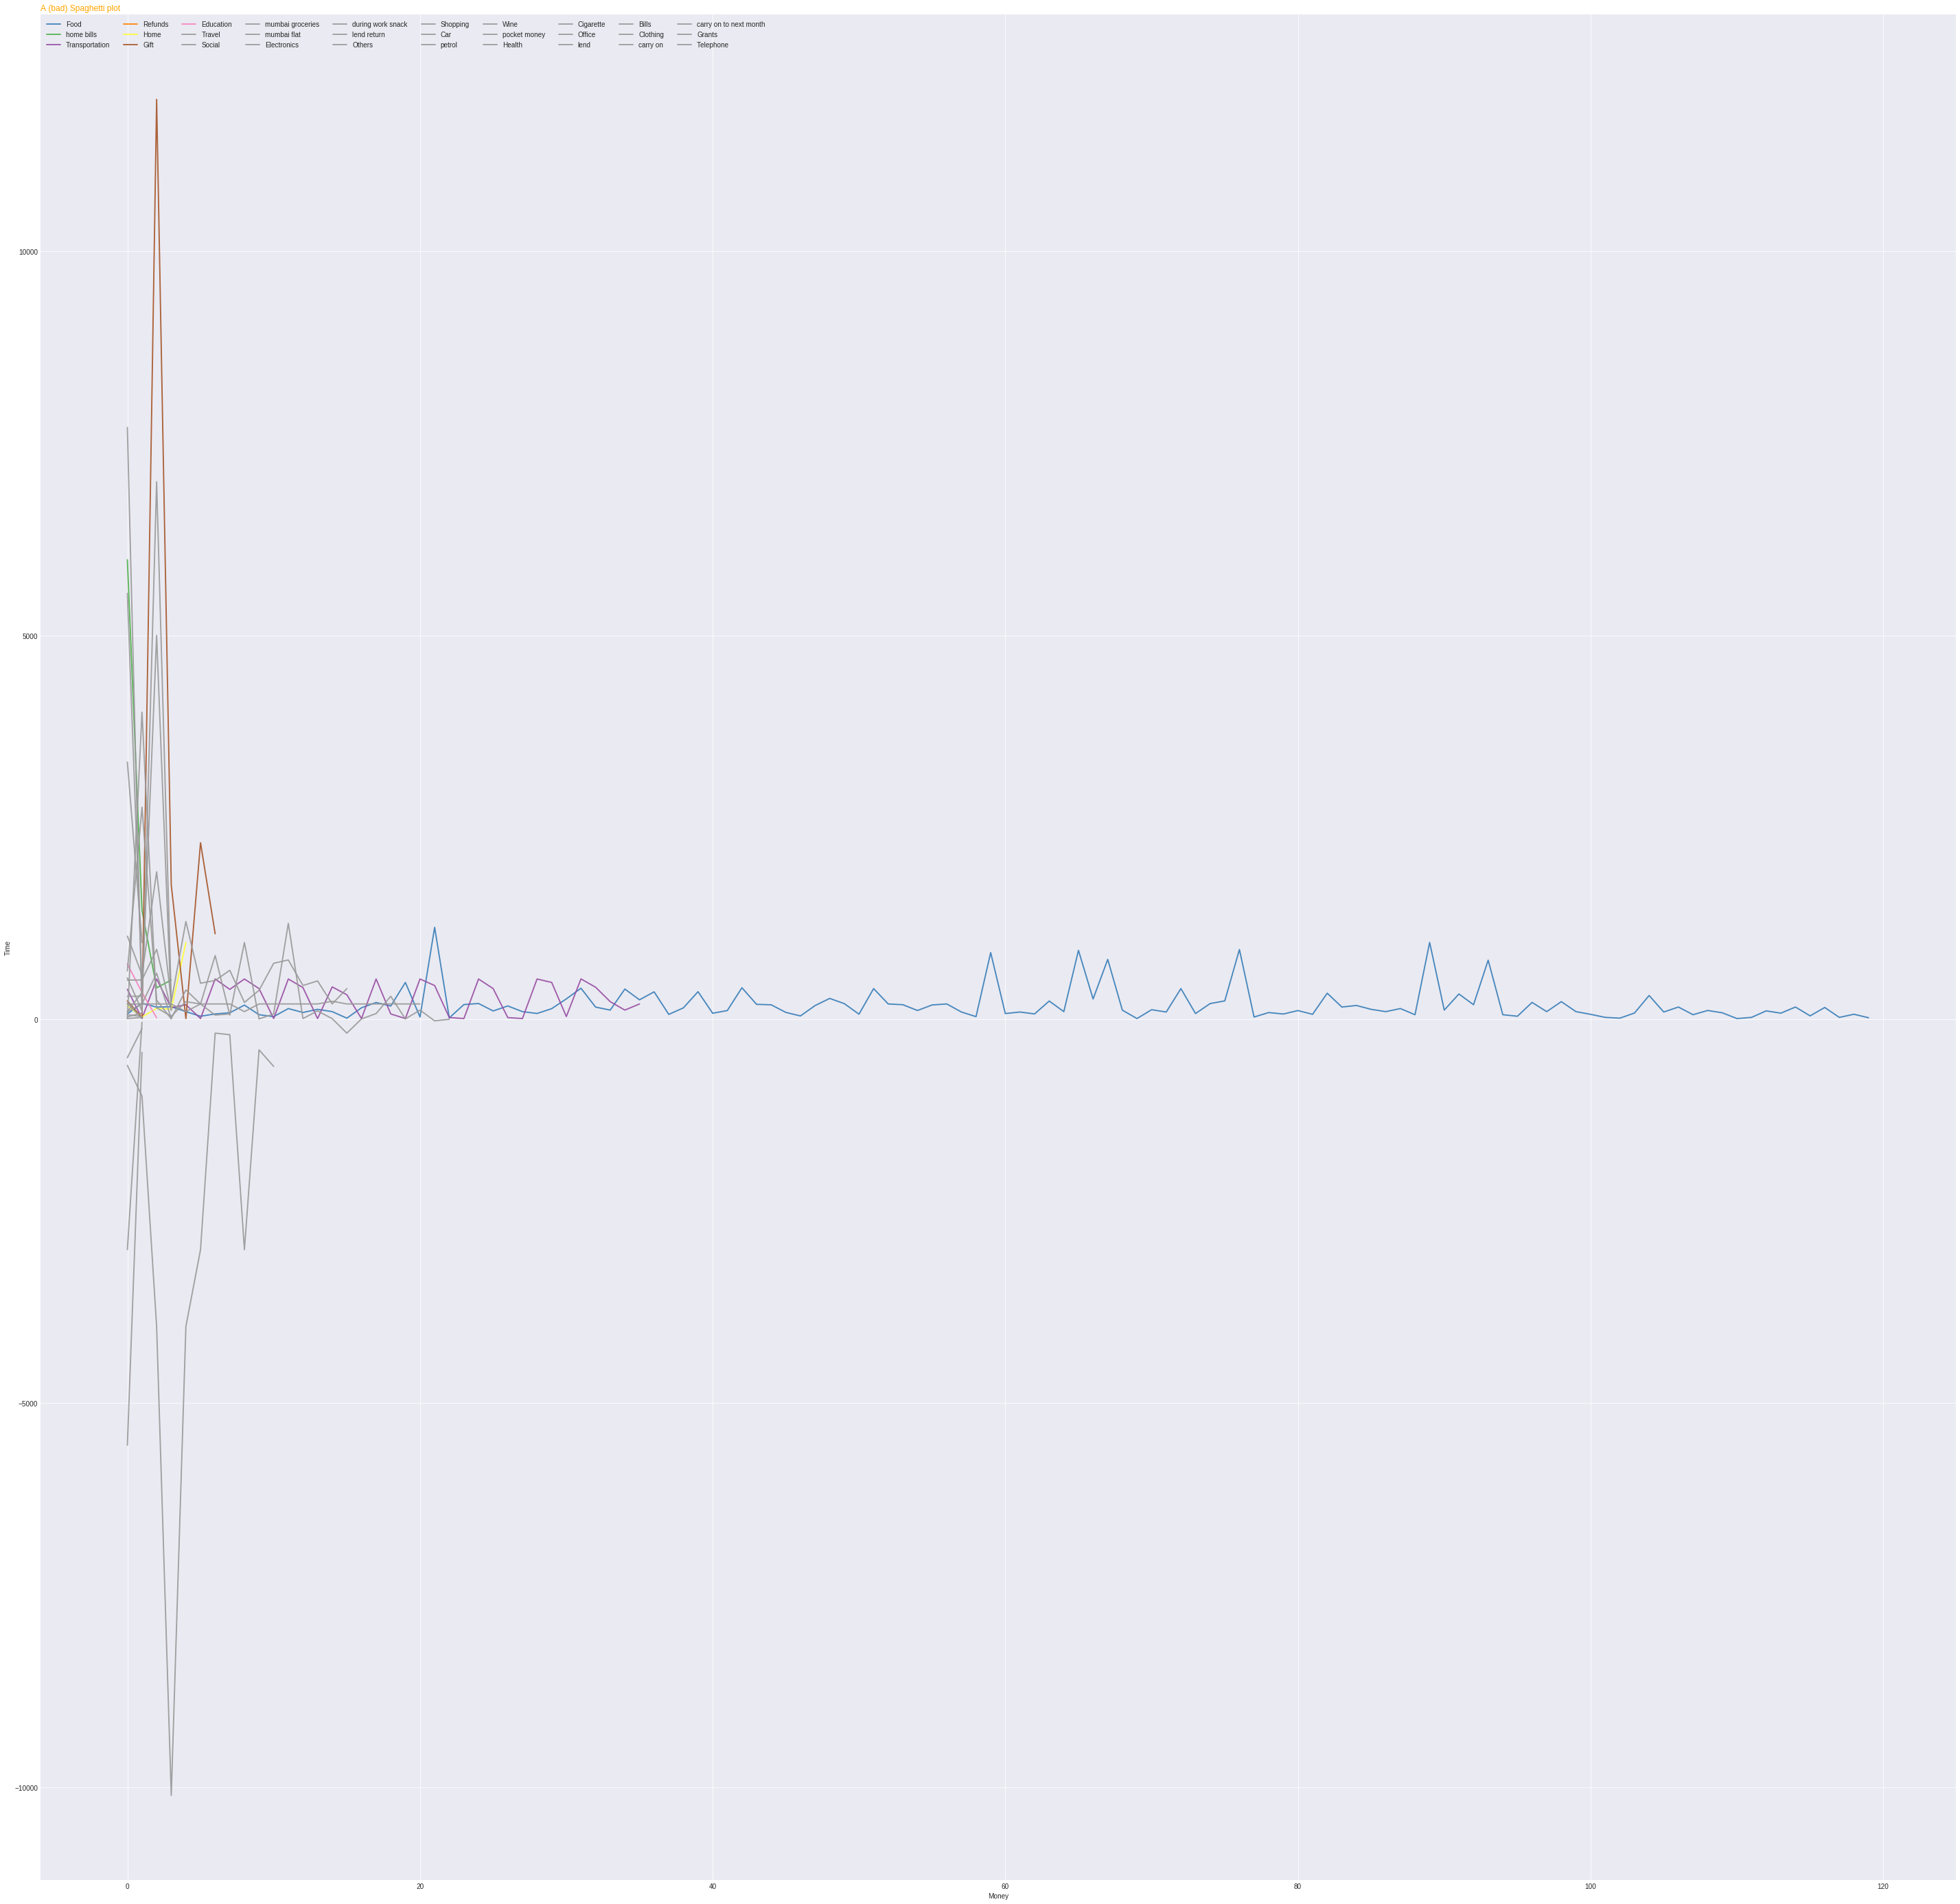

In [28]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(50,50))

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0

df = getDataForCategory(data.copy(), '', startDate , endDate, False)

for category in getCategories(): 
    num=num+1; 
    m = mergeDailyExpenseData(df.loc[df['Category'] == category])

    #if m['Amount'].empty == False:
    e= []
    if m.empty ==False:
        e = m['Amount'].values;



    if len(e)>size:
        size = e.size

    expenses.append(e)
    
    # Plot the lineplot
    plt.plot(list(range(0, len(e))), e, marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=category)
    
# Add legend
plt.legend(loc=2, ncol=10)
 
# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Money")
plt.ylabel("Time")

### Donut Plot

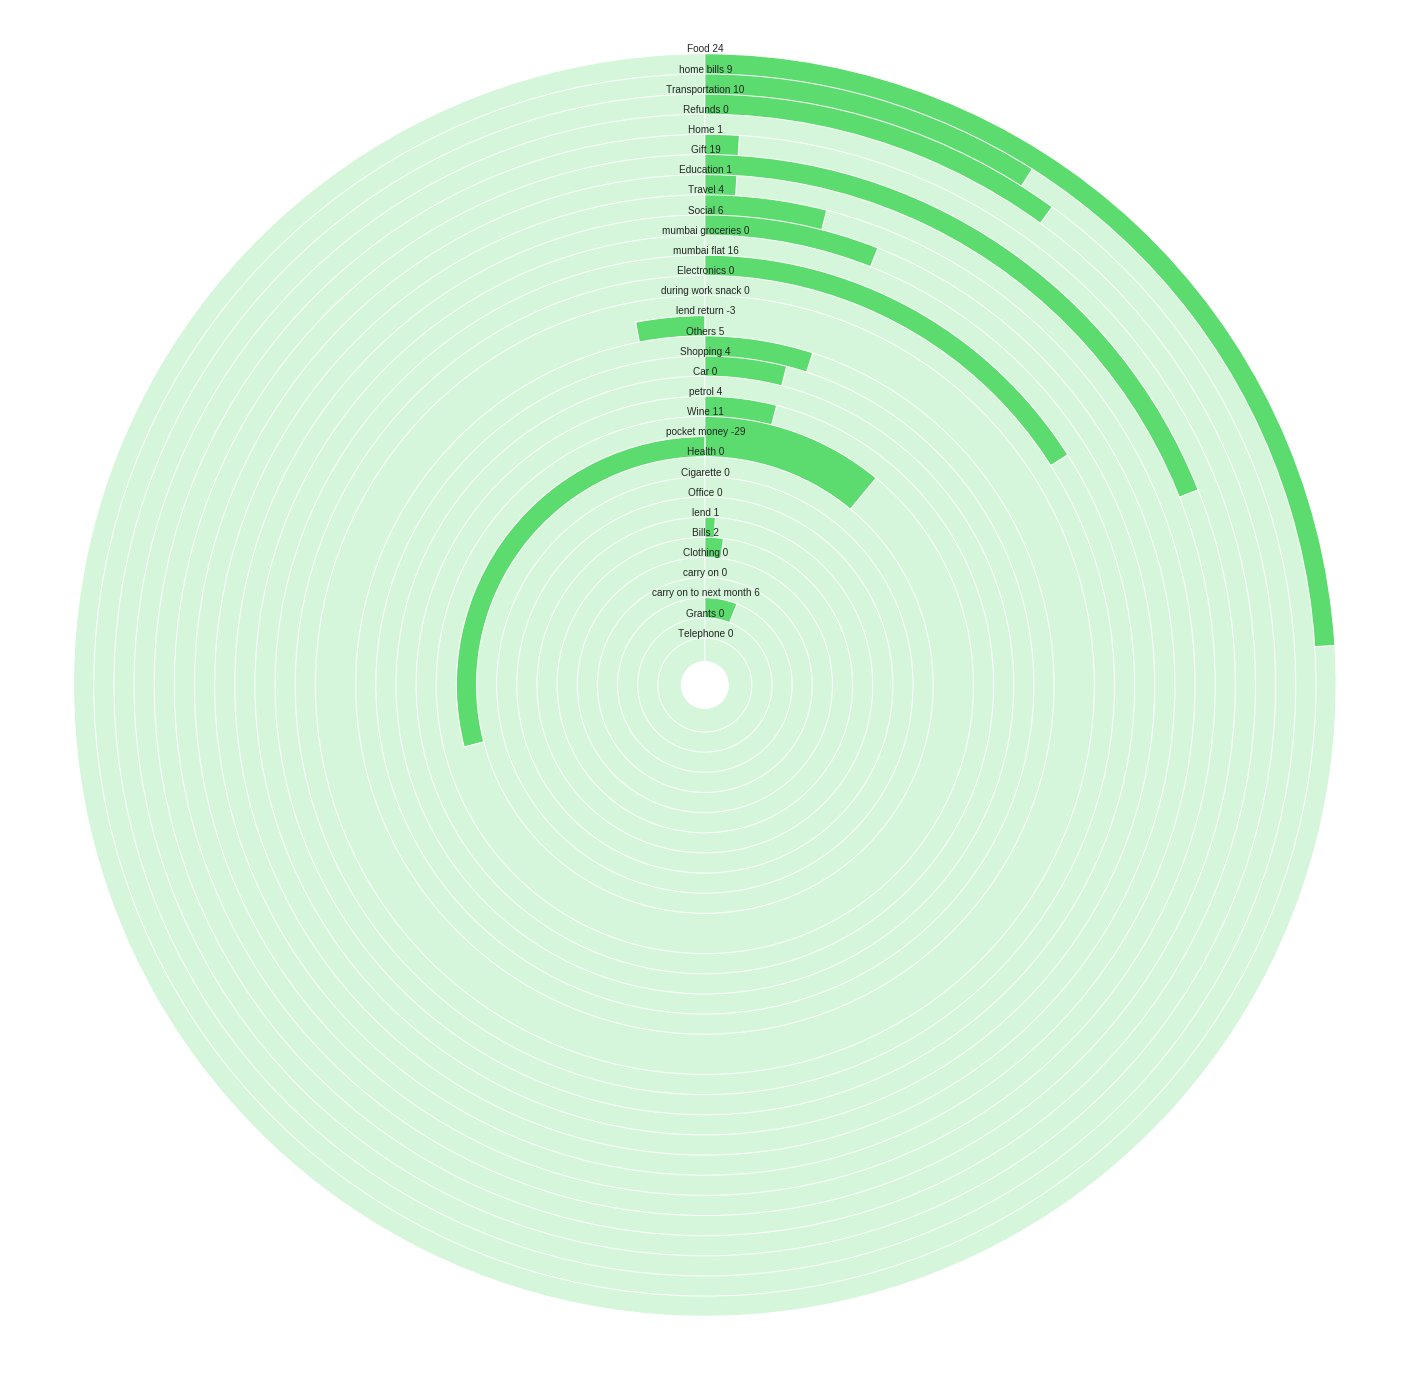

In [29]:
import pandas as pd
import re

import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

c = getCategories();
categorical_expenditure = getTotalExpenditure(data)
startingRadius = 0.7 + (0.3* (len(c)-1))
#print(categorical_expenditure)
ce = categorical_expenditure['Expense']
total_expense = np.sum(ce)
#print(total_expense)

for i in range(len(ce)):
    ce[i] = int((ce[i]/total_expense)*100);
    textLabel = c[i] + ' ' + str(ce[i])
    remainingPie = 100 - ce[i]
    donut_sizes = [remainingPie, ce[i]]
    
    plt.text(0.01, startingRadius + 0.07, textLabel, horizontalalignment='center', verticalalignment='center')
    plt.pie(donut_sizes, radius=startingRadius, startangle=90, colors=['#d5f6da', '#5cdb6f'], wedgeprops={"edgecolor": "white", 'linewidth': 1})
    
    startingRadius-=0.3

# equal ensures pie chart is drawn as a circle (equal aspect ratio)
plt.axis('equal')

# create circle and place onto pie chart
circle = plt.Circle(xy=(0, 0), radius=0.35, facecolor='white')
plt.gca().add_artist(circle)
plt.show()
